In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [135]:
beta = 100.
t = 1.

In [136]:
#definition of FourierTransforms
def matsubara_fft(G_tau):
    N = G_tau.shape[0]
    k = np.arange(N, dtype='float')
    return beta/N*np.fft.fft(G_tau*np.exp(1j*np.pi*k/N))
def matsubara_fft_trick(G_tau):
    N = G_tau.shape[0]
    freq = matsubara_freq(N)
    k = np.arange(N, dtype='float')
    return beta/N*np.fft.fft( (G_tau+0.5) *np.exp(1j*np.pi*k/N)) + 1./(1j*freq)
#numpy orders frequencies differently so one has to convert frequencies
def matsubara_freq(N):
    return np.pi/beta *(-2*(np.fft.fftfreq(N))*N+1)
def matsubara_ifft(G_omega):
    N = G_omega.shape[0]
    k = np.arange(N,dtype='float')
    return N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega)
#following has to be improved:
def matsubara_ifft_trick(G_omega):
    N = G_omega.shape[0]
    freq = matsubara_freq(N)
    k = np.arange(N,dtype='float')
    return -1/2+N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega-1./(1j*freq) )

In [137]:
N=501
tau = linspace(0,beta*(1.-1./N),N)
dtau = beta/N
freq = matsubara_freq(N)

In [138]:
def self_energy(G0_omega,U):
    G0_tau = matsubara_ifft_trick(G0_omega)
    #G0_product_tau = -U**2*G0_tau**3
    G0_minus_tau = -np.roll(G0_tau[::-1],1)
    G0_minus_tau[0] = -G0_minus_tau[0]
    G0_product_tau = -U**2 * G0_tau**2 * G0_minus_tau
    #G0_product_tau = -U**2 * G0_tau**3
    return matsubara_fft_trick(G0_product_tau)

In [140]:
from scipy.integrate import simps
Ne = N
Nk = N
k = linspace(-np.pi,np.pi, Nk)
epsilon_k = -2.*t*np.cos(k)
#D = 2.*t
D = 1.
def dos_bethe(e):
    return 2./(np.pi*D)*np.sqrt(1.-(e/D)**2)
def dos_cubic(e):
    return 1./(t*np.sqrt(2.*np.pi))*np.exp(-e**2/(2.*t))
def Gloc_omega(self_energy_omega):
    #return 1./Nk*np.sum(1./(1j*freq-epsilon_k[:, np.newaxis]-self_energy_omega),axis=0)
    ##
    energies_bethe = np.linspace(-D,D,Ne)
    denergies_bethe = energies_bethe[2] - energies_bethe[1]
    return simps( dos_bethe(energies_bethe)/(1j*freq[:,np.newaxis]-energies_bethe-self_energy_omega[:,np.newaxis]) ,dx=denergies_bethe)
    ##
    #energies_cubic = np.linspace(-10.*t,10*t,Ne)
    #denergies_cubic = energies_cubic[2] - energies_cubic[1]
    #return simps( dos_cubic(energies_cubic)/(1j*freq[:,np.newaxis]-energies_cubic-self_energy_omega[:,np.newaxis]) ,dx=denergies_cubic)

In [141]:
def DMFT_loop(G0_initial_omega,U,frac_new):
    G0_omega= G0_initial_omega
    #print "1/G0_initial = ", np.round(abs(1./G0_omega[::N/10]),2)
    self_e = self_energy(G0_omega,U)
    Gloc = Gloc_omega(self_e)
    G0_omega = frac_new * 1./(1./Gloc+self_e+U/2.) + (1.-frac_new) * G0_omega
    #print "1/Gloc = ", np.round(abs(1./Gloc[::N/10]),2)
    #print "Sigma = ", np.round(abs(self_e[::N/10]),2)
    #print "1/G0_new = ", np.round(abs(1./G0_omega[::N/10]),2)
    #print "-----------------------------------------------------------------------------------"
    return G0_omega, Gloc

In [142]:
def get_gloc(a,U,iterations,frac_new):
    G0 = 1. / ( 1j*freq + a )
    #G0 = np.random.rand(freq.shape[0]) + 1j* np.random.rand(freq.shape[0])
    #meanfreq = 10.
    #std = 0.5
    #G0 = 1./(np.sqrt(np.pi*2.)*std) * np.exp(-1./2*((freq-meanfreq)/(std))**2)
    g_0 = G0
    for i in range(iterations):
        g_0, g_loc = DMFT_loop(g_0,U,frac_new)
    return g_loc

In [143]:
def get_a_coeff(z_values, f_values): #z_values are the points at which we know the value of our function, f_values the values of our function at those points, z the point where we want to evaluate the continued fraction C_z;

    N = z_values.size
    
    g_mat = np.zeros([N,N],dtype=np.complex256) #this is the matrix whose elements are: g_mat[i,j] = g_i(z_j), cfr eqn. (A2). Note that only diagonal and upper diagonal elements matter. The coefficients a_i will be found on the diagonal: a_i = g_mat[i,i];
    #can be done diretly:
    g_mat[0]=f_values
    
    for i in range(N-1): #filling the rest of the matrix using the recursion relation;
        for j in range(N-(i+1)):
            g_mat[i+1,i+1+j] = (g_mat[i,i]-g_mat[i,j+i+1])/((z_values[j+1+i]-z_values[i])*g_mat[i,j+i+1])
    #also more effenciently:
    return np.diag(g_mat)

def C_z(a_coeff,z_values,z):
    N = a_coeff.size
    A = np.zeros(N+1,dtype=np.complex256)
    B = np.zeros(N+1,dtype=np.complex256)
    A[1] = a_coeff[0]
    B[0] = 1
    B[1] = 1
    
    for i in range(N-1):
        A[i+2] = A[i+1] + (z-z_values[i])*a_coeff[i+1]*A[i]
        B[i+2] = B[i+1] + (z-z_values[i])*a_coeff[i+1]*B[i]
        #if(np.abs(A[i+2])>1e600 or np.abs(B[i+2])>1e600 ):
            #print "overflow"

    return A[N]/B[N]

def analytic_continuation(freq,gloc,z):
    a_coeff = get_a_coeff(freq, gloc)
    f = lambda z: C_z(a_coeff,freq,z)
    fvectorized = np.vectorize(f)
    return fvectorized(z)

In [144]:
Gloc = get_gloc(2.,0,19,0.3)

fit_freq = freq[::5]
fit_Gloc = Gloc[::5]

In [145]:
fit_func = analytic_continuation(1j*fit_freq,fit_Gloc,1j*freq[::1])

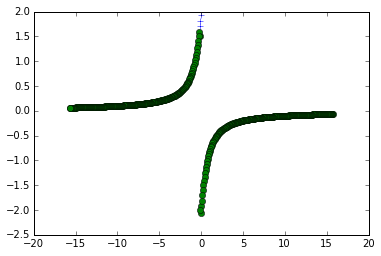

In [146]:
plt.plot(freq, Gloc.imag,'+')
plt.plot( freq[::1], fit_func.imag, 'o')

In [155]:
eta = 0.1
real_freq = np.linspace(-4.,4.,1001)

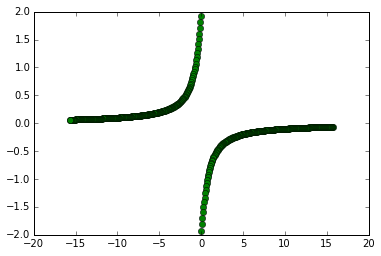

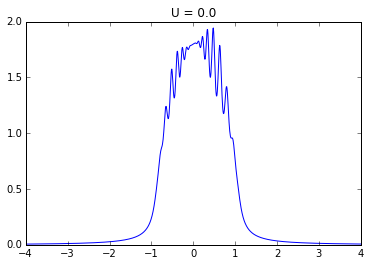

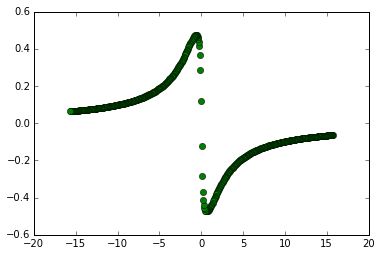

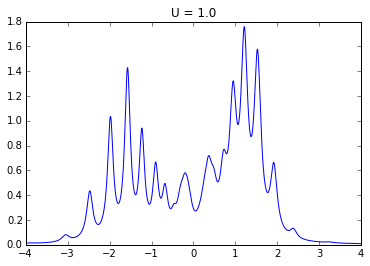

In [156]:
step = 1
for U in np.linspace(0.,1.,2):
    Gloc = get_gloc(2.,U,9,0.3)
    fit_Gloc = Gloc[::step]
    fit_freq = freq[::step]
    plt.plot(freq, Gloc.imag,'+')
    fit_func = analytic_continuation(1j*fit_freq,fit_Gloc,1j*freq)
    plt.plot( freq, fit_func.imag, 'o')
    plt.figure()
    spectral_func = analytic_continuation(1j*fit_freq,fit_Gloc,real_freq+1j*eta).imag
    plt.plot(real_freq,-spectral_func,'-')
    plt.title("U = {}".format(U))
    plt.figure()